# Install Requirements

In [ ]:
!pip -qq install transformers
!pip -qq install datasets
!pip -qq install soundfile
!pip -qq install speechbrain
!pip -qq install accelerate

# Import Libraries

In [31]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Any, Dict, List, Union
from dataclasses import dataclass
from IPython.display import Audio
import torch

from datasets import load_dataset, DatasetDict, Audio, concatenate_datasets
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from speechbrain.pretrained import EncoderClassifier



# Load Model

In [2]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/home/arh/anaconda3/envs/tts/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


# Load Dataset
common voice - Fa 

In [3]:
# Load the Common Voice dataset for Persian language, version 13.0
common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_13_0", "fa", split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_13_0", "fa", split="test", use_auth_token=True)

/home/arh/anaconda3/envs/tts/lib/python3.11/site-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/home/arh/anaconda3/envs/tts/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for mozilla-foundation/common_voice_13_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_13_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
# Cast the 'audio' column to the Audio format with a specific sampling rate
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [5]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 38464
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 10440
    })
})

In [6]:
# Merge the 'train' and 'test' splits
common_voice_merged = concatenate_datasets([common_voice["train"], common_voice["test"]])

In [7]:
common_voice_merged

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 48904
})

In [8]:
# Displaying the structure of the merged dataset
common_voice_merged_structure = common_voice_merged.features
common_voice_merged_structure

{'client_id': Value(dtype='string', id=None),
 'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'sentence': Value(dtype='string', id=None),
 'up_votes': Value(dtype='int64', id=None),
 'down_votes': Value(dtype='int64', id=None),
 'age': Value(dtype='string', id=None),
 'gender': Value(dtype='string', id=None),
 'accent': Value(dtype='string', id=None),
 'locale': Value(dtype='string', id=None),
 'segment': Value(dtype='string', id=None),
 'variant': Value(dtype='string', id=None)}

## Clean and Update Tokenizer

In [9]:
tokenizer = processor.tokenizer

In [10]:
# Define a function to extract all unique characters from a batch of sentences
def extract_all_chars(batch):
    all_text = " ".join(batch["sentence"])  # Combine all sentences into one string
    vocab = list(set(all_text))  # Create a list of unique characters
    return {"vocab": [vocab], "all_text": [all_text]}

# Use the 'map' function to apply the 'extract_all_chars' function to the 'train' split of the 'common_voice' dataset
vocabs = common_voice["train"].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=common_voice_merged.column_names,  # Remove unnecessary columns
)

# Get the unique characters from the extracted vocab
dataset_vocab = set(vocabs["vocab"][0])

# Get the unique characters from the tokenizer's vocabulary
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}


Map: 100%|█████████████████████| 38464/38464 [00:00<00:00, 565487.79 examples/s]


In [11]:
persian_char = dataset_vocab - tokenizer_vocab

replacements = [
    ('š', 'ش'),
    ('ā', 'آ'),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["sentence"] = inputs["sentence"].replace(src, dst)
    return inputs

common_voice_merged = common_voice_merged.map(cleanup_text)

In [12]:
# Extend the tokenizer's vocabulary
new_tokens = processor.tokenizer.add_tokens(list(persian_char))

# Verify that the new characters are added to the vocabulary
updated_vocab = processor.tokenizer.get_vocab()

In [13]:
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}
dataset_vocab - tokenizer_vocab

set()

# Speaker define 

In [14]:
speaker_counts = defaultdict(int)

for speaker_id in common_voice_merged["client_id"]:
    speaker_counts[speaker_id] += 1

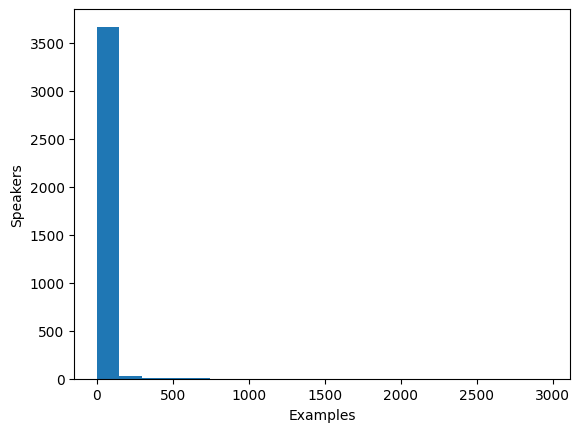

In [15]:
plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [16]:
def select_speaker(speaker_id):
    return 10 <= speaker_counts[speaker_id] <= 1000

common_voice_merged = common_voice_merged.filter(select_speaker, input_columns=["client_id"])

In [17]:
len(set(common_voice_merged["client_id"]))

546

# Speaker Embedding 

In [18]:
# Determine the device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load a pretrained speaker recognition model from SpeechBrain
# 'spk_model_name' should be the name of the desired speaker recognition model
speaker_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-xvect-voxceleb",
    run_opts={"device": device},
    savedir=os.path.join("/tmp", "speechbrain/spkrec-xvect-voxceleb")
)

# Define a function to create speaker embeddings from a given waveform
def create_speaker_embedding(waveform):
    with torch.no_grad():
        # Encode the input waveform to obtain speaker embeddings
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        
        # Normalize the speaker embeddings along the embedding dimension (L2 normalization)
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        
        # Squeeze the tensor to remove any unnecessary dimensions and move it to the CPU
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    
    return speaker_embeddings


# Map Dataset

In [19]:
def prepare_dataset(example):
    # load the audio data
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["sentence"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [20]:
# Test processing

processed_example = prepare_dataset(common_voice_merged[0])

print("processed_example.keys : " , list(processed_example.keys()))
print("Tokenizer : ", tokenizer.decode(processed_example["input_ids"]))

processed_example.keys :  ['input_ids', 'labels', 'speaker_embeddings']
Tokenizer :  ا و   خ و د   ر ا   ن ز د   خ و ی ش ا و ن د ا ن   پ و ل د ا ر   خ و د   خ و ا ر   و   خ ف ی ف   ک ر د.</s>


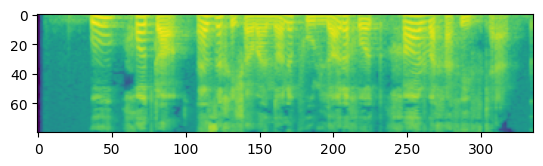

In [21]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [22]:
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [23]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [24]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [25]:
### Map Entire Dataset

common_voice_merged = common_voice_merged.map(
    prepare_dataset, remove_columns=common_voice_merged.column_names,
)

Map: 100%|████████████████████████| 29153/29153 [04:35<00:00, 105.64 examples/s]


In [26]:
# 600 token is for T5 filter length:

def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 600

common_voice_merged = common_voice_merged.filter(is_not_too_long, input_columns=["input_ids"])

Filter: 100%|██████████████████| 29153/29153 [00:00<00:00, 106725.75 examples/s]


In [27]:
len(common_voice_merged)

29153

# Split Dataset

In [28]:
common_voice_merged = common_voice_merged.train_test_split(test_size=0.1)

In [29]:
common_voice_merged

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 26237
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 2916
    })
})

# Data Collector

In [32]:
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [33]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

# Train

In [34]:
# Resize Model
model.resize_token_embeddings(len(tokenizer))

Embedding(165, 768)

In [35]:
model.config.use_cache = False

In [39]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./result",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    warmup_steps=500,
    max_steps=15000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

In [40]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice_merged["train"],
    eval_dataset=common_voice_merged["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

In [41]:
trainer.train()

Step,Training Loss,Validation Loss
500,0.652200,0.596390
1000,0.594500,0.547173
1500,0.583000,0.532736
2000,0.554800,0.549387
2500,0.552800,0.515771
3000,0.540400,0.504940
3500,0.523500,0.494592
4000,0.524600,0.501942
4500,0.513200,0.493860
5000,0.499700,0.482784


/home/arh/anaconda3/envs/tts/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/arh/anaconda3/envs/tts/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/arh/anaconda3/envs/tts/lib/python3.11/site-packa

TrainOutput(global_step=15000, training_loss=0.5071517230987549, metrics={'train_runtime': 15800.5241, 'train_samples_per_second': 30.379, 'train_steps_per_second': 0.949, 'total_flos': 2.4585384444569784e+16, 'train_loss': 0.5071517230987549, 'epoch': 18.29})

# Test Trained Model

In [42]:
# obtain a speaker embedding. We can simply grab one from the test set.
example = common_voice_merged["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

In [43]:
model.to("cpu")

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(165, 768)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
            (layer_

In [45]:
text = "این یک تست میباشد"
tokenizer.decode(tokenizer(text)["input_ids"])
inputs = processor(text=text, return_tensors="pt")
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad():
    speech = vocoder(spectrogram)

In [46]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)  

In [48]:
import soundfile as sf
sf.write("output3.wav", speech.numpy(), samplerate=16000)